In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# Để tái tạo
torch.manual_seed(42)
np.random.seed(42)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [20]:
# Import the necessary transformations module from torchvision
import torchvision.transforms as transforms

# Define a transformation pipeline. 
# Here, we're only converting the images to PyTorch tensor format.
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [22]:
#tạo basic CNN

In [24]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # Input: [batch_size, 1, 28, 28]
        self.conv1 = nn.Conv2d(1, 32, 3)  # Output: [batch_size, 32, 26, 26]
        
        # Input: [batch_size, 32, 26, 26]
        self.conv2 = nn.Conv2d(32, 64, 3) # Output: [batch_size, 64, 11, 11]
        
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Flattening: [batch_size, 64*5*5]
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input: [batch_size, 1, 28, 28]
        x = F.relu(self.conv1(x))
        # Shape: [batch_size, 32, 26, 26]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 32, 13, 13]
        
        x = F.relu(self.conv2(x))
        # Shape: [batch_size, 64, 11, 11]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 64, 5, 5]
        
        x = x.view(-1, 64 * 5 * 5) # Flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [26]:
#training and evaluation

In [28]:
# Khởi tạo mô hình
model = BasicCNN().to(device)

In [30]:
# Tối ưu hóa và Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [31]:
# Number of complete passes through the dataset
num_epochs = 5

# Start the training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    # Iterate over each batch of the training data
    for images, labels in trainloader:
        # Move the images and labels to the computational device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients from the previous iteration
        optimizer.zero_grad()
        
        # Forward pass: Pass the images through the model to get the predicted outputs
        outputs = model(images)
        
        # Compute the loss between the predicted outputs and the true labels
        loss = criterion(outputs, labels)
        
        # Backward pass: Compute the gradient of the loss w.r.t. model parameters
        loss.backward()
        
        # Update the model parameters
        optimizer.step()

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.79      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.79      0.89      0.84      1000
       Dress       0.89      0.93      0.91      1000
        Coat       0.88      0.75      0.81      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.67      0.74      0.71      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



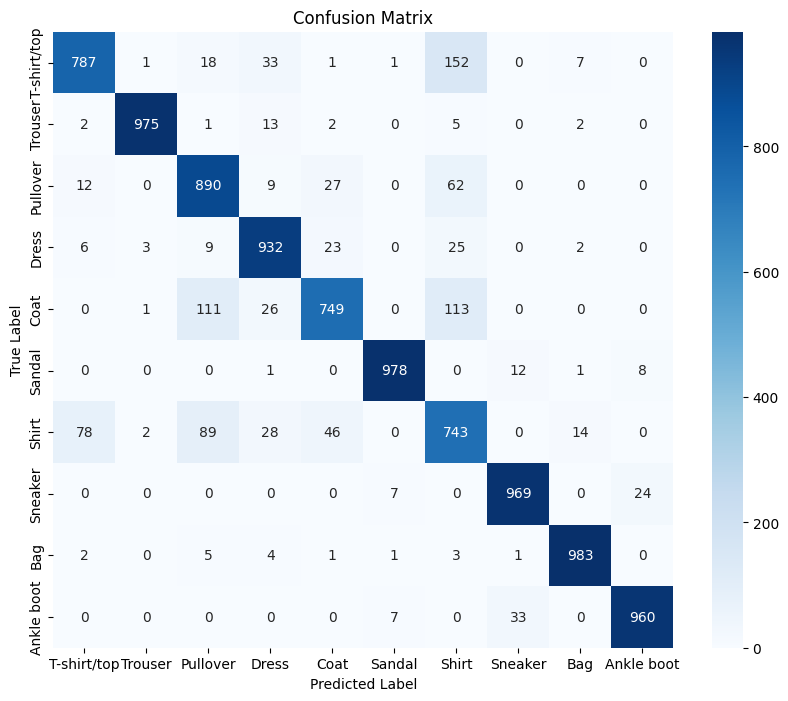

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Set the model to evaluation mode. This is important as certain layers like dropout behave differently during training and evaluation.
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# We don't want to compute gradients during evaluation, hence wrap the code inside torch.no_grad()
with torch.no_grad():
    # Iterate over all batches in the test loader
    for images, labels in testloader:
        # Transfer images and labels to the computational device (either CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Pass the images through the model to get predictions
        outputs = model(images)
        
        # Get the class with the maximum probability as the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Extend the all_preds list with predictions from this batch
        all_preds.extend(predicted.cpu().numpy())
        
        # Extend the all_labels list with true labels from this batch
        all_labels.extend(labels.cpu().numpy())

# Print a classification report which provides an overview of the model's performance for each class
print(classification_report(all_labels, all_preds, target_names=classes))

# Compute the confusion matrix using true labels and predictions
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class NetDropout(nn.Module):
    def __init__(self):
        super(NetDropout, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Output shape: [batch_size, 32, 28, 28]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # Output shape: [batch_size, 64, 14, 14]
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Reduces spatial dimensions by half
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)  # Helps prevent overfitting
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Flattened input to 512 output features
        self.fc2 = nn.Linear(512, 10)          # 512 input features to 10 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Shape: [batch_size, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x))) # Shape: [batch_size, 64, 7, 7]
        
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = self.dropout(x)         # Apply dropout
        
        x = F.relu(self.fc1(x))     # First fully connected layer with ReLU activation
        x = self.fc2(x)             # Second fully connected layer
        
        # Here, we're not applying log_softmax. If you use nn.CrossEntropyLoss as the loss function later,
        # it will implicitly apply softmax for you.
        # If you plan on using nn.NLLLoss, uncomment the line below:
        # x = F.log_softmax(x, dim=1)
        
        return x

# Instantiate the model with dropout
model_dropout = NetDropout().to(device)
model_dropout

NetDropout(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [34]:
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Number of complete passes through the dataset
num_epochs = 5

# Start the training loop
for epoch in range(num_epochs):
    # Initialize a variable to keep track of the cumulative loss for this epoch
    running_loss = 0.0
    
    # Set the model to training mode
    model_dropout.train()
    
    # Iterate over each batch of the training data
    for i, (images, labels) in enumerate(trainloader):
        # Move the images and labels to the computational device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients from the previous iteration
        optimizer.zero_grad()
        
        # Forward pass: Pass the images through the model to get the predicted outputs
        outputs = model_dropout(images)
        
        # Compute the loss between the predicted outputs and the true labels
        loss = criterion(outputs, labels)
        
        # Backward pass: Compute the gradient of the loss w.r.t. model parameters
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Print the average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

print("Finished Training")

Epoch [1/5], Loss: 0.3897


In [1]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode. This is important as certain layers like dropout behave differently during training and evaluation.
model_dropout.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# We don't want to compute gradients during evaluation, hence wrap the code inside torch.no_grad()
with torch.no_grad():
    # Iterate over all batches in the test loader
    for images, labels in testloader:
        # Transfer images and labels to the computational device (either CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Pass the images through the model to get predictions
        outputs = model_dropout(images)
        
        # Get the class with the maximum probability as the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Extend the all_preds list with predictions from this batch
        all_preds.extend(predicted.cpu().numpy())
        
        # Extend the all_labels list with true labels from this batch
        all_labels.extend(labels.cpu().numpy())

# Print a classification report which provides an overview of the model's performance for each class
print(classification_report(all_labels, all_preds, target_names=classes))

# Compute the confusion matrix using true labels and predictions
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot

NameError: name 'model_dropout' is not defined